1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

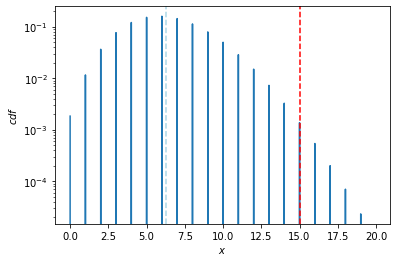

Z = 3.4661629670697414
p-value = 0.0005279431738299246
This number is signficantly different


In [2]:
from math import sqrt, pi, erf
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

x0 = 15.
mu = 6.3
#probability of 15 hurricans
# plot the measurement and its assumed pdf
w = mu - x0
x = np.arange(0, 20, 0.1)
y = stats.poisson.pmf(x, 6.3, 0)
#probability that in a single year are observed 15 or more hurricances.
#print(1-stats.poisson.cdf(x0,6.3,0))
plt.plot(x, y)
plt.axvline(x0, linestyle='--', color='red')
plt.axvline(mu, linestyle='--', color='lightblue')
plt.ylabel("$cdf$")
plt.xlabel("$x$")
plt.yscale("log")
plt.show()
#------------------------------------------------------------------------------
sigma=np.sqrt(mu)
Z = abs(x0 - mu) / sigma
print("Z =", Z)
pvalue =  stats.norm.cdf(-Z) +(1. - stats.norm.cdf(Z))
print("p-value =", pvalue)
print('This number is signficantly different')

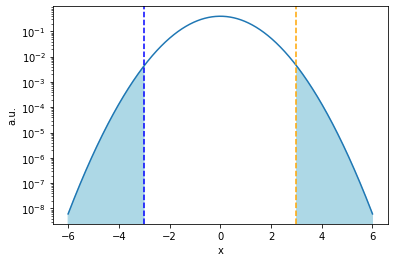

p-value = 0.0026997960632601965


In [3]:
# plot the test statistics and its pdf
Z=3
xs = np.linspace(-6, +6, 1000)
ts = stats.norm.pdf(xs)
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=np.abs(xs) > np.abs(Z), color='lightblue')
plt.axvline(Z, linestyle='--', color='orange')
plt.axvline(-Z, linestyle='--', color='blue')
plt.ylabel("a.u.")
plt.xlabel("x")
plt.yscale("log")
plt.show()

pvalue = stats.norm.cdf(-Z) + (1. - stats.norm.cdf(Z))
print("p-value =", pvalue)

2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [4]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
sigma_1 = np.sqrt(np.var(pre, ddof=1)) 
sigma_2 = np.sqrt(np.var(post, ddof=1)) 
mean_1 = np.mean(pre) 
mean_2 = np.mean(post)
n = 10
\
# calculate the test statistics
sigma=np.sqrt(((sigma_1**2)+(sigma_2**2))/2)
T = (mean_1 - mean_2) / (sigma / np.sqrt(2/n))
print("T =", T)

xs = np.linspace(-5, +5, 1000)
ts = stats.t.pdf(xs, n - 1)


pvalue = stats.t.cdf(T, n - 1) + (1. - stats.t.cdf(-T, n - 1))
print("p-value =", pvalue)
print('change is not statistically significant')

T = -0.7573995876275257
p-value = 0.4681758060603869
change is not statistically significant


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

In [5]:
! wget https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt

--2022-01-16 19:57:24--  https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3vigxoqayo389uc/populations.txt [following]
--2022-01-16 19:57:25--  https://www.dropbox.com/s/raw/3vigxoqayo389uc/populations.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1e153a3e8715da1f7adfaa1da7.dl.dropboxusercontent.com/cd/0/inline/Bd6NzhrmjldUtPo6aSr4T5GQAg4pjwGvNBMBLXbvpOuGwR7uH3LfcRpoElU8bPG-hXbwGIIAxM8eCETD62ayqY4R_dSCP8j1PUKkrVzQ12AvIVBOq_fnK_Wx7ShRkUoLZ8lGKoOqkOBFRYJZ5_2kQTjp/file# [following]
--2022-01-16 19:57:26--  https://uc1e153a3e8715da1f7adfaa1da7.dl.dropboxusercontent.com/cd/0/inline/Bd6NzhrmjldUtPo6aSr4T5GQAg4pjwGvNBMBLXbvpOuGwR7uH3LfcRpoElU8bPG-hXbwGIIAxM8eCE

In [6]:
data = np.loadtxt('populations.txt.1')
year, hares, lynxes, carrots = data.T 


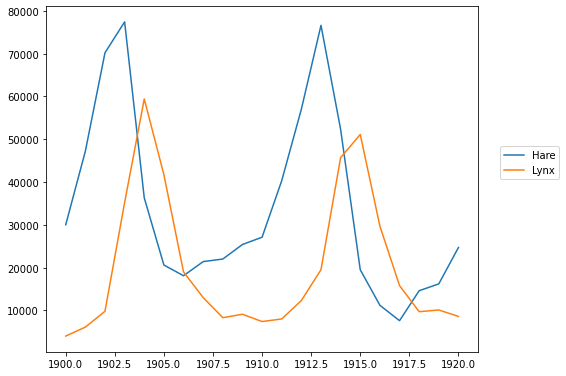

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.axes([0.2, 0.1, 0.5, 0.8]) 
plt.plot(year, hares, year, lynxes) 
plt.legend(('Hare', 'Lynx'), loc=(1.05, 0.5)) 

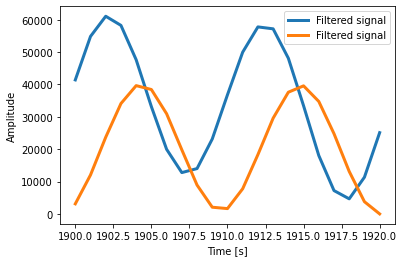

In [8]:
from scipy import fftpack
sig_fft = fftpack.fft(data.T[1])
sample_freq=fftpack.fftfreq(21,d=1)

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
power = np.abs(sig_fft)
powes = power[pos_mask]

peak_freq = freqs[powes.argmax()]
filtered_sig = fftpack.ifft(sample_freq)
# only take the real part
high_freq_fft = sig_fft.copy()
# filter (set to zero) all high frequency components that are larger than peak_freq
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
# calculate the Inverse Fast Fourier Transform
filtered_sig = fftpack.ifft(high_freq_fft)
# only take the real part
real_filtered_signal = np.real(filtered_sig)



plt.plot(year, real_filtered_signal, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')


sig_fft = fftpack.fft(data.T[2])
sample_freq=fftpack.fftfreq(21,d=1)

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
power = np.abs(sig_fft)
powes = power[pos_mask]

peak_freq = freqs[powes.argmax()]
filtered_sig = fftpack.ifft(sample_freq)
# only take the real part
high_freq_fft = sig_fft.copy()
# filter (set to zero) all high frequency components that are larger than peak_freq
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
# calculate the Inverse Fast Fourier Transform
filtered_sig = fftpack.ifft(high_freq_fft)
# only take the real part
real_filtered_signal = np.real(filtered_sig)



plt.plot(year, real_filtered_signal, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')


4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

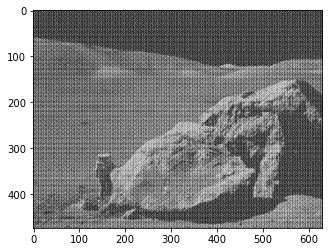

In [32]:
from scipy.fftpack import fft2, ifft2
from matplotlib.colors import LogNorm


a=plt.imread("moonlanding.png")
plt.imshow(a,plt.cm.gray)

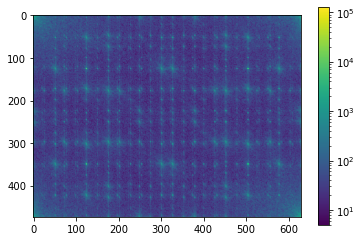

In [33]:
#performs a 2D FFT
im_fft = fftpack.fft2(a)

#plot power spectrum of Fourier transform
plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
plt.colorbar()

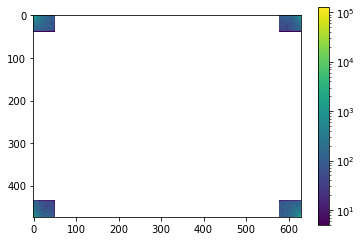

In [34]:

coefficients = 0.08
im_fft2 = im_fft.copy()
#rows and columns of the array
r, c = im_fft2.shape

#Use array slicing to set the noise regions to zero
im_fft2[int(r*coefficients):int(r*(1-coefficients))] = 0
im_fft2[:, int(c*coefficients):int(c*(1-coefficients))] = 0

plt.imshow(np.abs(im_fft2), norm=LogNorm(vmin=5))
plt.colorbar()

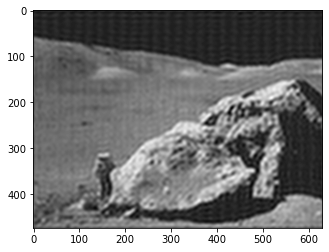

In [35]:
#perform inverse FFT with zero noise
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new, plt.cm.gray)
